In [1]:
import numpy as np
import pandas as pd
import os
import csv
from datetime import datetime
import json
import matplotlib.pyplot as plt

In [2]:
# Read in relevant data

quals = pd.read_csv('./kaggle_csvs/qualifying.csv')
drivers = pd.read_csv('./kaggle_csvs/drivers.csv')
races = pd.read_csv('./kaggle_csvs/races.csv')
lap_times = pd.read_csv('./kaggle_csvs/lap_times.csv')
lap_times = lap_times.sort_values(['raceId','driverId','lap'],ascending=[True,True,True])
pits = pd.read_csv('./kaggle_csvs/pit_stops.csv')
results = pd.read_csv('./kaggle_csvs/results.csv')
status = pd.read_csv('./kaggle_csvs/status.csv')

In [3]:
# Create Directories for Race Files

dirs = [name for name in os.listdir('./races/') if os.path.isdir(os.path.join('./races/', name))]
for index, row in races.iterrows():
    name = str(row['year']) + ' ' + str(row['name'])
    d_n = './races/' + name
    if name not in dirs:
        os.mkdir(d_n)

In [4]:
# Parse files for timing, places, and intervals

# list all directories
dirs = [name for name in os.listdir('./races/') if os.path.isdir(os.path.join('./races/', name))]

# set blank for writing to CSVs
times = []
racer = []
places = []
first = lap_times.iloc[0]
race = lap_times.iloc[0]['raceId']
last = lap_times.iloc[-1]['raceId']
race_row = races.loc[races['raceId'] == last]

# if the file does not already exist
if not os.path.exists("./races/{} {}/total_times.csv".format(race_row['year'].item(),race_row['name'].item())):
    
    #for all laps
    for index, row in lap_times.iterrows():
        
        #if the first lap
        if row['lap'] == 1:

            if racer != []:
                times.append(racer)
                racer = []
                
            # add leading variables
            racer.append(row['raceId'])
            racer.append(row['driverId'])
            racer.append(drivers.loc[drivers['driverId'] == row['driverId']]['driverRef'].item())
            final_pos = results.loc[(results['raceId'] == race) & (results['driverId'] == row['driverId'])]
            racer.append(final_pos['constructorId'].item())
            racer.append(final_pos['positionOrder'].item())
            racer.append(final_pos['statusId'].item())
            st = status.loc[status['statusId'] == final_pos['statusId'].item()]
            racer.append(st['status'].item())
            racer.append(row['milliseconds'])
            header = ['raceId','driverId','driverRef','constructorId','positionOrder','statusId','status']
        
        # else, add the new lap
        else:
            racer.append(row['milliseconds']+racer[-1])
            
        # if the last lap has been completed, write to file
        if index == len(lap_times.index)-1 or lap_times.iloc[[index+1]]['raceId'].item() != race:
            
            # add relevant values to the total time lists
            race_row = races.loc[races['raceId'] == race]
            times.append(racer)
            total_times = pd.DataFrame(times)
            total_times = total_times.sort_values(7)
            total_times = total_times.drop(total_times.index[-1])
            
            # add headers for lap number and write
            for c in total_times.columns:
                if int(c) > 6:
                    header.append(int(c)-6)
            total_times.columns = header
            total_times.to_csv("./races/{} {}/total_times.csv".format(race_row['year'].item(),race_row['name'].item()))

            # for all times in total times, find the place of the driver and write
            for ind,r in total_times.iterrows():
                dr = [r['driverRef']]
                for c in total_times.columns:
                    if isinstance(c,int):
                        if r[c] != 0 and not pd.isna(r[c]):
                            dr.append(total_times[total_times[c]<r[c]].count()[c]+1)
                        else:
                            dr.append(0)
                places.append(dr)

            places = pd.DataFrame(places)
            places.to_csv("./races/{} {}/places.csv".format(race_row['year'].item(),race_row['name'].item()))

            #find the interval times and write
            intervals = np.array(total_times)
            for i in range(7,len(intervals[0])):
                intervals[:,i] -= np.nanmin(intervals[:,i])

            intervals = pd.DataFrame(intervals)
            intervals = intervals.drop(intervals.index[-1])
            intervals.to_csv("./races/{} {}/intervals.csv".format(race_row['year'].item(),race_row['name'].item()))

            if index != len(lap_times.index)-1:
                # reset variables
                race = lap_times.iloc[[index+1]]['raceId'].item()
                times = []
                racer = []
                places = []
            
print('done')

done


In [5]:
#function for comparing two lists with positions and copying the positions between the two for sorting
def complists(l1,l2):
    
    #sort lists based on position
    l1 = l1.sort_values(4,ignore_index=True)
    l2 = l2.sort_values(4,ignore_index=True)
    d1 = l1.iloc[:,3]
    d2 = l2.iloc[:,3]
    
    # corrolate lists
    order = []
    for i,d in l1.iterrows():
        if d[3] in list(d2):
            order.append([d[0],d[1],d[2],d[3],d2[d2==d[3]].index.values[0],l1.loc[l1[3] == d[3], 3].iloc[0]])
    
    #return previous lap ordering with current positions
    order = pd.DataFrame(order)
    order = np.array(order)
    return order

In [6]:
def swap(arr,j,orders,qt,n_pass,v_pass,pit=False):
    
    n_laps = orders[arr[j][1]][3]
    
    if j == 0:
        orders[arr[j+1][1]] = [None,0,arr[j][3],0]
        orders[arr[j][1]] = [arr[j+1][3],0,arr[2][3],0]
        behind = orders[arr[j+2][1]]
        orders[arr[j+2][1]] = [arr[j][3],0,behind[2],behind[3]]
    elif j == len(arr)-2:
        orders[arr[j+1][1]] = [arr[j-1][3],0,arr[j][3],0]
        orders[arr[j][1]] = [arr[j+1][3],0,None,0]
        ahead = orders[arr[j-1][1]]
        orders[arr[j-1][1]] = [ahead[0],ahead[1],arr[j+1][3],0]
    else:
        orders[arr[j+1][1]] = [arr[j-1][3],0,arr[j][3],0]
        orders[arr[j][1]] = [arr[j+1][3],0,arr[j+2][3],0]
        behind = orders[arr[j+2][1]]
        orders[arr[j+2][1]] = [arr[j][3],0,behind[2],behind[3]]
        ahead = orders[arr[j-1][1]]
        orders[arr[j-1][1]] = [ahead[0],ahead[1],arr[j+1][3],0]
        
    if pit:
        arr[j], arr[j+1] = arr[j+1], arr[j]
        return
    
    tf = qt[qt[0] == int(arr[j+1][1])]
    
    if len(tf.index) == 0 or tf[2].item() == '3:00.00':
        d = [arr[j+1][1],arr[j+1][2]]
        temp = qt[qt[1] == int(arr[j+1][2])]
        d.append(temp[2].min())
        tf = pd.DataFrame([d])
        
        if pd.isna(tf[2].item()):
            return 0,0
    
    """
    if int(arr[j+1][1]) in qt[0].unique():
        tf = qt[qt[0] == int(arr[j+1][1])]
    elif int(arr[j+1][2]) in qt[1].unique():
        tf = qt[qt[1] == int(arr[j+1][2])]
    else:
        print('tf')
        return 0,0
    """
    
    ts = qt[qt[0] == int(arr[j][1])]
    
    if len(ts.index) == 0 or ts[2].item() == '3:00.00':
        d = [arr[j][1],arr[j][2]]
        temp = qt[qt[1] == int(arr[j][2])]
        d.append(temp[2].min())
        ts = pd.DataFrame([d])
        
        if pd.isna(ts[2].item()):
            return 0,0
    
    """
    # set the time of the passed based on qualifying or a teammates qualification
    if int(arr[j][1]) in qt[0].unique():
        ts = qt[qt[0] == arr[j][1]]
    elif int(arr[j][2]) in qt[1].unique():
        ts = qt.loc[qt[1] == int(arr[j][2])]
    else:
        print('ts')
        return 0,0
    """

    #convert to datetime
    qf = datetime.strptime(tf[2].item(), '%M:%S.%f')
    qs = datetime.strptime(ts[2].item(), '%M:%S.%f')
        
    f_laps = list(orders[arr[j+1][1]])
    s_laps = list(orders[arr[j][1]])

    v_f = v_pass[arr[j+1][3]]
    #should i be using a ratio or subtraction
    v_pass[arr[j+1][3]] = [round(v_f[0]+(1/(f_laps[1]+1)*(2**((qf-qs).total_seconds()/100))),5),v_f[1]]
    v_s = v_pass[arr[j][3]]
    #should i be using a ratio or subtraction
    v_pass[arr[j][3]] = [v_s[0],round(v_s[1]+(s_laps[3]+1)*2**((qs-qf).total_seconds()/100),5)]

    n_f = n_pass[arr[j+1][3]]
    n_pass[arr[j+1][3]] = [n_f[0]+1,n_f[1]]
    n_s = n_pass[arr[j][3]]
    n_pass[arr[j][3]] = [n_s[0],n_s[1]+1]
    arr[j], arr[j+1] = arr[j+1], arr[j]
    
    return (qs-qf).total_seconds(),n_laps

In [7]:
#bubble sort lists. Fast because mosly ordered. Makes tracking overtaking easy because of the bubble method
def bubbleSort(arr,n_pass,v_pass,qt,orders,pits):
    #set number of laps and set total overtakes to 0
    n = len(arr)
    ot = 0
    times = []
    
    #for each row, bubble sort
    for i in range(n):
        for j in range(0,n-1-i):
            #if the position is higher than the one below
            if arr[j][4] > arr[j+1][4]:
                if int(arr[j+1][1]) in pits or int(arr[j][1]) in pits:
                    diff = swap(arr,j,orders,qt,n_pass,v_pass,pit=True)
                else:
                    diff,laps = swap(arr,j,orders,qt,n_pass,v_pass)
                    ot += 1
                    times.append([diff,laps])
                
    return ot, times

In [8]:
def overtakes(filename,n_pass,v_pass,pits,quals,dr_o,dr_p,rm=True):
    if os.path.exists(filename):
        diffs = []
        print(filename)
        laptimes = pd.read_csv(filename)
        raceId = laptimes['raceId']
        if int(raceId[0]) > 840:
            driverId = laptimes['driverId']
            constructorId = laptimes['constructorId']
            racers = laptimes.iloc[:,3]
            prev = laptimes.iloc[:,8]
            prev = pd.concat([raceId,driverId,constructorId,racers,prev],keys=[0,1,2,3,4],axis=1)
            orders = {}
            for p in range(len(prev)):
                if p == 0:
                    orders[prev[1][p]] = [None,0,prev[1][p+1],0]
                elif p == len(prev)-1:
                    orders[prev[1][p]] = [prev[1][p-1],0,None,0]
                else:
                    orders[prev[1][p]] = [prev[1][p-1],0,prev[1][p+1],0]
            stops = pits.loc[pits['raceId'] == raceId[0]]
            qt = quals.loc[quals['raceId'] == raceId[0]]
            if qt.empty:
                return
            did = [list(qt['driverId']),list(qt['constructorId'])]
            qt[['q1','q2','q3']] = qt[['q1','q2','q3']].fillna('3:00.00')
            qt[['q1','q2','q3']] = qt[['q1','q2','q3']].replace(r"\N",'3:00.00')
            qt[['q1','q2','q3']] = qt[['q1','q2','q3']].replace(r"\\N",'3:00.00')
            did.append(list(qt[['q1','q2','q3']].dropna().min(axis=1)))
            did = list(map(list, zip(*did)))
            qt = pd.DataFrame(did)
            tot_ots = 0
            l_b = {}
            for r in laptimes['driverRef']:
                l_b[r] = []
            for c in laptimes.columns[8:]:
                times = laptimes[c]
                times = pd.concat([raceId,driverId,constructorId,racers,times],keys=[0,1,2,3,4],axis=1)
                times.dropna(subset = [4], inplace=True)
                pitted = []
                if rm:
                    if int(c)-1 in list(stops['lap']):
                        rows = stops[stops['lap'] == int(c)-1]
                        for i,r in rows.iterrows():
                            times = times[times[1] != r[1]]
                            prev = prev[prev[1] != r[1]]
                            pitted.append(r[1])
                changes = complists(prev,times)
                ots, diff = bubbleSort(changes,n_pass,v_pass,qt,orders,pitted)
                for d in diff:
                    if abs(d[0])> 3:
                        print(d)
                tot_ots += ots
                diffs = diffs + diff
                for i in range(len(times.index)):
                    if i == len(times.index)-1:
                        t = times.iloc[i]
                        l = l_b[t[3]]
                        ods = orders[t[1]]
                        l.append([ods[1],ods[3]])
                        l_b[t[3]] = l
                        continue
                    f = times.iloc[i]
                    s = times.iloc[i+1]
                    if abs(f[4]-s[4])/1000 < 1.2:
                        odf = orders[f[1]]
                        ods = orders[s[1]]
                        orders[f[1]] = [odf[0],odf[1],odf[2],odf[3]+1]
                        orders[s[1]] = [ods[0],ods[1]+1,ods[2],ods[3]]
                    odf = orders[f[1]]
                    l = l_b[f[3]]
                    l.append([odf[1],odf[3]])
                    l_b[f[3]] = l
                prev = laptimes[c]
                prev = pd.concat([raceId,driverId,constructorId,racers,prev],keys=[0,1,2,3,4],axis=1)
            with open('{}total_overtakes.txt'.format(filename[:-15]), 'w') as f:
                f.write('%d' % tot_ots)
            with open('{}laps.txt'.format(filename[:-15]), 'w') as convert_file:
                convert_file.write(json.dumps(l_b))
                
        return diffs

In [9]:
n_pass = {}
v_pass ={}
dr_o = {}
dr_p = {}
diffs = []
for r in drivers['driverRef']:
    n_pass[r] = [0,0]
    v_pass[r] = [0,0]
    dr_o[r] = []
    dr_p[r] = []
#print(1)
for d in dirs:
    diff = overtakes('./races/{}/total_times.csv'.format(d),n_pass,v_pass,pits,quals,dr_o,dr_p)
    if diff != None:
        diffs = diffs + diff

for k in list(n_pass.keys()):
    if n_pass[k] == [0,0]:
        n_pass.pop(k)
    if v_pass[k] == [0,0]:
        v_pass.pop(k)
    if dr_o[k] == []:
        dr_o.pop(k)
    if dr_p[k] == []:
        dr_p.pop(k)

./races/2005 San Marino Grand Prix/total_times.csv
./races/2015 Monaco Grand Prix/total_times.csv
[3.893, 1]
[-3.893, 0]
[4.142, 0]
[3.893, 0]
[3.711, 1]
[3.462, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2000 San Marino Grand Prix/total_times.csv
./races/2000 Canadian Grand Prix/total_times.csv
./races/2018 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Monaco Grand Prix/total_times.csv
./races/2012 Japanese Grand Prix/total_times.csv
[3.531, 0]
[4.836, 0]
[3.531, 0]
[4.836, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.534, 0]
[3.531, 0]
[3.315, 1]
./races/2010 Korean Grand Prix/total_times.csv
./races/2013 Spanish Grand Prix/total_times.csv
[3.426, 1]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 British Grand Prix/total_times.csv
./races/2009 Australian Grand Prix/total_times.csv
./races/2016 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 British Grand Prix/total_times.csv
[3.36, 1]
[3.204, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Emilia Romagna Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 Monaco Grand Prix/total_times.csv
./races/2014 Belgian Grand Prix/total_times.csv
[7.823, 0]
[4.214, 0]
[-3.176, 1]
[3.33, 0]
[5.079, 0]
[4.037, 0]
[3.54, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[8.619, 2]
[4.493, 5]
[5.079, 0]
[3.681, 0]
[3.481, 0]
[5.011, 0]
[3.176, 0]
[-3.986, 0]
[3.055, 0]
[3.176, 0]
./races/2004 Chinese Grand Prix/total_times.csv
./races/2002 Brazilian Grand Prix/total_times.csv
./races/2018 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 British Grand Prix/total_times.csv
./races/2000 Brazilian Grand Prix/total_times.csv
./races/2008 British Grand Prix/total_times.csv
./races/2014 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Abu Dhabi Grand Prix/total_times.csv
[4.538, 0]
[3.401, 0]
[5.778, 0]
[4.641, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Chinese Grand Prix/total_times.csv
[3.24, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.587, 1]
[3.619, 0]
./races/2002 German Grand Prix/total_times.csv
./races/2003 Monaco Grand Prix/total_times.csv
./races/2007 Malaysian Grand Prix/total_times.csv
./races/1996 Italian Grand Prix/total_times.csv
./races/2001 European Grand Prix/total_times.csv
./races/2007 Turkish Grand Prix/total_times.csv
./races/2020 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 German Grand Prix/total_times.csv
./races/2021 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 United States Grand Prix/total_times.csv
[4.077, 0]
[3.469, 0]
[4.579, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.222, 0]
[3.262, 0]
./races/2019 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 French Grand Prix/total_times.csv
[3.236, 0]
[3.329, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 Spanish Grand Prix/total_times.csv
./races/2015 Japanese Grand Prix/total_times.csv
[4.582, 1]
[12.94, 0]
[4.609, 0]
[12.913, 1]
[4.582, 0]
[4.261, 0]
[13.617, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[5.286, 0]
[-8.331, 1]
[-8.331, 1]
./races/2017 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 Belgian Grand Prix/total_times.csv
./races/2014 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 Chinese Grand Prix/total_times.csv
./races/2012 Brazilian Grand Prix/total_times.csv
[6.995, 0]
[-6.995, 0]
[6.323, 0]
[4.851, 0]
[4.851, 0]
[3.82, 0]
[6.21, 0]
[5.002, 0]
[4.255, 0]
[6.21, 0]
[4.255, 0]
[3.584, 0]
[6.401, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.086, 0]
[4.521, 0]
[-4.615, 0]
[3.174, 0]
[4.492, 1]
[6.087, 0]
[6.21, 1]
[3.597, 0]
[4.957, 0]
[5.08, 0]
[-3.584, 0]
[-3.597, 0]
[3.485, 0]
[-3.775, 0]
[3.53, 0]
[3.775, 0]
[3.775, 0]
[3.775, 0]
[4.806, 0]
[3.53, 0]
[-3.597, 0]
./races/2011 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.054, 1]
[3.173, 0]
[3.106, 16]
[3.079, 0]
[-3.079, 0]
[-3.079, 0]
./races/1997 Australian Grand Prix/total_times.csv
./races/2004 Japanese Grand Prix/total_times.csv
./races/2007 Hungarian Grand Prix/total_times.csv
./races/1997 German Grand Prix/total_times.csv
./races/2014 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.2, 0]
[3.183, 0]
[3.207, 0]
./races/2000 Hungarian Grand Prix/total_times.csv
./races/1997 Austrian Grand Prix/total_times.csv
./races/1997 Japanese Grand Prix/total_times.csv
./races/2012 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Hungarian Grand Prix/total_times.csv
[4.058, 1]
[5.928, 1]
[5.104, 0]
[4.424, 0]
[4.013, 0]
[3.234, 1]
[4.077, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.525, 2]
[3.234, 0]
[4.077, 0]
./races/1997 Hungarian Grand Prix/total_times.csv
./races/2018 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 French Grand Prix/total_times.csv
./races/2018 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 European Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 Canadian Grand Prix/total_times.csv
./races/2001 Japanese Grand Prix/total_times.csv
./races/2006 Turkish Grand Prix/total_times.csv
./races/2001 Malaysian Grand Prix/total_times.csv
./races/2013 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Russian Grand Prix/total_times.csv
[-3.841, 2]
[-4.357, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[-5.247, 0]
[6.322, 0]
[-4.964, 0]
[-5.239, 0]
[-5.896, 0]
[-5.594, 4]
[-5.308, 0]
[-5.975, 0]
./races/2006 Australian Grand Prix/total_times.csv
./races/2018 United States Grand Prix/total_times.csv
[3.437, 0]
[3.064, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Canadian Grand Prix/total_times.csv
./races/2000 United States Grand Prix/total_times.csv
./races/2012 Korean Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 British Grand Prix/total_times.csv
./races/2003 Japanese Grand Prix/total_times.csv
./races/2005 French Grand Prix/total_times.csv
./races/2019 Japanese Grand Prix/total_times.csv
[3.111, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.091, 0]
./races/2012 Singapore Grand Prix/total_times.csv
[3.895, 0]
[3.939, 0]
[3.546, 2]
[3.939, 0]
[4.581, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.422, 0]
[4.287, 0]
[3.895, 0]
[3.662, 0]
[3.162, 0]
./races/2019 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Belgian Grand Prix/total_times.csv
./races/1999 Australian Grand Prix/total_times.csv
./races/1997 Canadian Grand Prix/total_times.csv
./races/2016 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 Spanish Grand Prix/total_times.csv
./races/2005 British Grand Prix/total_times.csv
./races/2012 Abu Dhabi Grand Prix/total_times.csv
[4.052, 1]
[4.078, 0]
[4.353, 0]
[3.883, 0]
[3.096, 0]
[4.163, 0]
[4.146, 4]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.469, 0]
[4.078, 0]
[4.353, 0]
[3.806, 0]
[3.883, 0]
[3.336, 0]
[3.137, 0]
[3.682, 0]
[3.067, 0]
./races/2018 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 British Grand Prix/total_times.csv
./races/2007 Spanish Grand Prix/total_times.csv
./races/2005 German Grand Prix/total_times.csv
./races/2019 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 United States Grand Prix/total_times.csv
./races/2001 San Marino Grand Prix/total_times.csv
./races/2002 Hungarian Grand Prix/total_times.csv
./races/2010 Belgian Grand Prix/total_times.csv
./races/2005 Brazilian Grand Prix/total_times.csv
./races/2001 Brazilian Grand Prix/total_times.csv
./races/2004 Spanish Grand Prix/total_times.csv
./races/2014 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Abu Dhabi Grand Prix/total_times.csv
[3.399, 1]
[3.399, 0]
[3.62, 2]
[3.562, 0]
[3.825, 0]
[4.08, 1]
[3.459, 0]
[3.767, 0]
[4.285, 0]
[3.436, 0]
[3.275, 0]
[3.641, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.01, 0]
[3.537, 7]
[3.479, 0]
[3.997, 0]
[3.436, 0]
[3.353, 0]
./races/1999 Malaysian Grand Prix/total_times.csv
./races/1997 Spanish Grand Prix/total_times.csv
./races/2009 Italian Grand Prix/total_times.csv
./races/2019 United States Grand Prix/total_times.csv
[3.341, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Spanish Grand Prix/total_times.csv
./races/2014 Russian Grand Prix/total_times.csv
[4.56, 0]
[4.599, 0]
[4.042, 0]
[-3.006, 0]
[3.013, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.355, 0]
./races/2003 Brazilian Grand Prix/total_times.csv
./races/2017 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 French Grand Prix/total_times.csv
./races/2004 United States Grand Prix/total_times.csv
./races/2008 European Grand Prix/total_times.csv
./races/2005 Japanese Grand Prix/total_times.csv
./races/2016 Australian Grand Prix/total_times.csv
[3.681, 0]
[4.222, 0]
[4.222, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[-3.338, 0]
./races/2003 Malaysian Grand Prix/total_times.csv
./races/2020 Tuscan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2004 Monaco Grand Prix/total_times.csv
./races/2012 Belgian Grand Prix/total_times.csv
[3.022, 1]
[5.159, 0]
[5.159, 0]
[5.159, 0]
[7.118, 0]
[-7.118, 0]
[3.25, 0]
[4.465, 0]
[5.622, 0]
[5.159, 0]
[3.238, 0]
[7.118, 0]
[3.868, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.329, 0]
[4.126, 0]
./races/2017 Italian Grand Prix/total_times.csv
[4.891, 1]
[3.53, 0]
[3.648, 0]
[7.242, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[7.242, 0]
[-3.018, 0]
[4.376, 0]
./races/2010 British Grand Prix/total_times.csv
./races/1999 Hungarian Grand Prix/total_times.csv
./races/1996 Hungarian Grand Prix/total_times.csv
./races/2013 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Japanese Grand Prix/total_times.csv
[4.323, 1]
[3.398, 0]
[3.338, 1]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[-3.157, 1]
[4.238, 0]
./races/2009 Abu Dhabi Grand Prix/total_times.csv
./races/1997 San Marino Grand Prix/total_times.csv
./races/2010 Brazilian Grand Prix/total_times.csv
./races/2008 Spanish Grand Prix/total_times.csv
./races/2004 British Grand Prix/total_times.csv
./races/2012 British Grand Prix/total_times.csv
[3.563, 1]
[3.265, 0]
[7.1, 0]
[5.997, 0]
[5.699, 0]
[4.575, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.265, 0]
[7.694, 0]
[5.169, 0]
./races/2000 Malaysian Grand Prix/total_times.csv
./races/2005 Spanish Grand Prix/total_times.csv
./races/2011 European Grand Prix/total_times.csv
[3.939, 1]
[4.09, 0]
[3.939, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.166, 0]
[3.424, 0]
./races/2003 British Grand Prix/total_times.csv
./races/2004 Hungarian Grand Prix/total_times.csv
./races/2006 European Grand Prix/total_times.csv
./races/2004 French Grand Prix/total_times.csv
./races/2010 German Grand Prix/total_times.csv
./races/2020 Emilia Romagna Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Italian Grand Prix/total_times.csv
./races/2017 Singapore Grand Prix/total_times.csv
[-3.549, 2]
[3.501, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Portuguese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Australian Grand Prix/total_times.csv
./races/2006 Spanish Grand Prix/total_times.csv
./races/2006 Japanese Grand Prix/total_times.csv
./races/1997 European Grand Prix/total_times.csv
./races/2002 Spanish Grand Prix/total_times.csv
./races/2018 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Singapore Grand Prix/total_times.csv
[3.187, 0]
[4.969, 10]
[3.729, 2]
[-3.825, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[5.148, 0]
[5.148, 0]
[6.139, 0]
[3.245, 0]
[3.825, 0]
[4.148, 0]
[3.252, 0]
[3.252, 0]
[3.701, 0]
./races/2006 Italian Grand Prix/total_times.csv
./races/2020 70th Anniversary Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2004 Brazilian Grand Prix/total_times.csv
./races/1999 Italian Grand Prix/total_times.csv
./races/2019 Abu Dhabi Grand Prix/total_times.csv
[3.41, 1]
[3.141, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Chinese Grand Prix/total_times.csv
[3.399, 0]
[3.968, 0]
[3.023, 2]
[3.865, 0]
[4.347, 0]
[4.862, 0]
[3.399, 0]
[3.383, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.292, 0]
[3.049, 0]
[3.368, 0]
./races/2006 British Grand Prix/total_times.csv
./races/1996 Australian Grand Prix/total_times.csv
./races/2020 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.049, 0]
./races/2005 Malaysian Grand Prix/total_times.csv
./races/1999 San Marino Grand Prix/total_times.csv
./races/2018 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.278, 0]
./races/2019 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.445, 2]
[3.445, 0]
[3.408, 1]
[3.408, 0]
[3.006, 0]
[3.006, 0]
[3.408, 0]
./races/2019 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 Japanese Grand Prix/total_times.csv
./races/2004 Malaysian Grand Prix/total_times.csv
./races/2009 Japanese Grand Prix/total_times.csv
./races/1996 Brazilian Grand Prix/total_times.csv
./races/2015 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 Bahrain Grand Prix/total_times.csv
./races/2020 Sakhir Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Hungarian Grand Prix/total_times.csv
./races/2007 European Grand Prix/total_times.csv
./races/2019 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.542, 0]
[3.762, 0]
[3.166, 0]
[3.571, 0]
./races/2005 Bahrain Grand Prix/total_times.csv
./races/1996 Argentine Grand Prix/total_times.csv
./races/2005 United States Grand Prix/total_times.csv
./races/2010 Abu Dhabi Grand Prix/total_times.csv
./races/2007 Bahrain Grand Prix/total_times.csv
./races/2012 European Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.391, 0]
[-3.391, 0]
[3.391, 0]
./races/2021 Styrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 European Grand Prix/total_times.csv
./races/2013 Australian Grand Prix/total_times.csv
[-7.777, 3]
[-10.887, 4]
[7.486, 0]
[-7.324, 0]
[9.867, 2]
[-7.324, 0]
[10.477, 0]
[-7.857, 0]
[18.552, 1]
[19.162, 0]
[-8.829, 1]
[9.105, 0]
[11.371, 0]
[17.79, 0]
[8.572, 0]
[12.493, 0]
[11.407, 0]
[8.998, 0]
[-9.611, 0]
[8.685, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[11.813, 0]
[7.876, 0]
[-9.765, 0]
[8.572, 1]
[11.215, 0]
[11.215, 0]
[12.463, 0]
[9.644, 0]
[19.949, 0]
[17.257, 0]
[12.073, 0]
[10.727, 0]
[-7.876, 0]
[10.951, 0]
[-7.324, 0]
[8.734, 0]
[8.247, 0]
[18.763, 0]
[7.857, 0]
[7.486, 0]
[8.685, 0]
[-10.727, 2]
[-9.765, 0]
[-8.421, 0]
[-10.951, 0]
[-9.641, 0]
[-7.486, 0]
[9.543, 0]
[9.396, 0]
[10.951, 0]
[9.641, 0]
[10.047, 0]
./races/2017 British Grand Prix/total_times.csv
[-11.993, 0]
[12.033, 1]
[11.977, 0]
[11.977, 0]
[-12.366, 0]
[-13.417, 0]
[-11.484, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[-13.548, 0]
[13.559, 0]
[11.111, 0]
[11.151, 0]
[11.993, 0]
[-11.973, 0]
[-12.033, 0]
[-14.064, 0]
[-13.892, 0]
[13.084, 0]
[-14.11, 0]
[-15.61, 0]
./races/2012 German Grand Prix/total_times.csv
[3.489, 0]
[3.171, 0]
[3.965, 1]
[3.647, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.026, 0]
[4.009, 0]
[3.691, 0]
[3.07, 0]
[3.804, 0]
./races/2005 Australian Grand Prix/total_times.csv
./races/2004 Canadian Grand Prix/total_times.csv
./races/2000 Spanish Grand Prix/total_times.csv
./races/2000 Japanese Grand Prix/total_times.csv
./races/2013 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[5.615, 3]
[5.615, 0]
[-11.498, 0]
[4.15, 8]
[-7.719, 0]
[3.344, 0]
[-7.719, 0]
[-10.619, 4]
[10.619, 0]
[12.481, 0]
[12.095, 0]
[4.255, 0]
[3.509, 1]
./races/2005 Chinese Grand Prix/total_times.csv
./races/2002 British Grand Prix/total_times.csv
./races/2016 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 European Grand Prix/total_times.csv
./races/2003 Canadian Grand Prix/total_times.csv
./races/2012 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1997 Monaco Grand Prix/total_times.csv
./races/2012 Malaysian Grand Prix/total_times.csv
[4.592, 0]
[4.245, 0]
[5.437, 0]
[6.178, 0]
[6.178, 0]
[5.037, 0]
[5.924, 0]
[5.778, 0]
[-5.778, 0]
[-6.991, 0]
[5.031, 0]
[5.778, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.845, 0]
[6.991, 0]
[4.586, 0]
[3.314, 0]
[3.314, 0]
[3.02, 0]
[4.535, 0]
[3.199, 0]
./races/2013 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Japanese Grand Prix/total_times.csv
./races/2016 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1999 French Grand Prix/total_times.csv
./races/2018 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2004 Bahrain Grand Prix/total_times.csv
./races/2010 Singapore Grand Prix/total_times.csv
./races/2012 Indian Grand Prix/total_times.csv
[3.068, 1]
[3.067, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.63, 0]
[4.679, 0]
[3.517, 0]
./races/2016 Bahrain Grand Prix/total_times.csv
[3.336, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1999 German Grand Prix/total_times.csv
./races/2000 German Grand Prix/total_times.csv
./races/2021 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 Italian Grand Prix/total_times.csv
./races/2016 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Hungarian Grand Prix/total_times.csv
./races/2014 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.536, 0]
./races/2008 Japanese Grand Prix/total_times.csv
./races/2016 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 German Grand Prix/total_times.csv
./races/2020 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Turkish Grand Prix/total_times.csv
./races/2003 United States Grand Prix/total_times.csv
./races/2020 Eifel Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Turkish Grand Prix/total_times.csv
[16.759, 1]
[19.651, 0]
[10.514, 3]
[-4.074, 0]
[13.321, 0]
[-3.951, 0]
[-17.272, 0]
[11.311, 0]
[20.287, 1]
[4.721, 0]
[-5.298, 0]
[16.448, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[15.072, 0]
[13.062, 0]
[-5.811, 0]
[-3.815, 1]
[11.461, 0]
[11.461, 0]
[-3.239, 0]
[-7.404, 1]
[-6.248, 0]
[17.272, 0]
[-7.645, 0]
[-8.641, 0]
[-4.962, 0]
[-5.298, 0]
[-3.35, 0]
[-7.18, 0]
./races/2002 Austrian Grand Prix/total_times.csv
./races/2011 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.056, 0]
[3.543, 0]
[3.85, 0]
[4.05, 0]
[3.952, 0]
[3.29, 0]
[3.161, 0]
[4.439, 0]
[3.667, 0]
[3.216, 0]
./races/2015 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.673, 0]
[4.225, 0]
./races/2000 European Grand Prix/total_times.csv
./races/2017 Bahrain Grand Prix/total_times.csv
[3.071, 0]
[3.071, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.549, 0]
./races/2006 German Grand Prix/total_times.csv
./races/2004 Belgian Grand Prix/total_times.csv
./races/2012 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1999 Austrian Grand Prix/total_times.csv
./races/2002 Monaco Grand Prix/total_times.csv
./races/2007 Belgian Grand Prix/total_times.csv
./races/2020 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 Italian Grand Prix/total_times.csv
./races/1997 French Grand Prix/total_times.csv
./races/2002 Malaysian Grand Prix/total_times.csv
./races/2015 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 French Grand Prix/total_times.csv
./races/2004 German Grand Prix/total_times.csv
./races/2008 Hungarian Grand Prix/total_times.csv
./races/2009 German Grand Prix/total_times.csv
./races/2010 Hungarian Grand Prix/total_times.csv
./races/2011 Turkish Grand Prix/total_times.csv
[3.12, 1]
[5.443, 1]
[4.324, 0]
[4.571, 0]
[3.377, 0]
[3.552, 0]
[3.209, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 Chinese Grand Prix/total_times.csv
./races/1998 Spanish Grand Prix/total_times.csv
./races/2012 Spanish Grand Prix/total_times.csv
[5.325, 1]
[3.57, 0]
[3.274, 1]
[3.8, 1]
[4.54, 0]
[3.605, 0]
[4.578, 0]
[4.135, 0]
[3.907, 0]
[3.855, 0]
[3.59, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Malaysian Grand Prix/total_times.csv
[3.548, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.273, 0]
[3.254, 0]
[5.15, 1]
[5.131, 0]
[3.239, 0]
[3.393, 0]
[-3.393, 0]
[3.393, 0]
[4.338, 0]
./races/2013 British Grand Prix/total_times.csv
[6.251, 2]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.079, 2]
[3.059, 0]
[4.073, 0]
./races/2006 French Grand Prix/total_times.csv
./races/2012 Australian Grand Prix/total_times.csv
[3.837, 1]
[4.494, 0]
[5.007, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.26, 0]
[-4.26, 0]
./races/2002 French Grand Prix/total_times.csv
./races/2001 Monaco Grand Prix/total_times.csv
./races/2012 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[5.402, 0]
[4.971, 0]
[3.112, 0]
[4.993, 0]
[4.289, 0]
./races/2018 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Malaysian Grand Prix/total_times.csv
./races/1997 Italian Grand Prix/total_times.csv
./races/2019 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Malaysian Grand Prix/total_times.csv
./races/2014 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.556, 0]
[5.058, 0]
[-6.223, 0]
./races/2014 Singapore Grand Prix/total_times.csv
[4.979, 1]
[4.475, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[5.298, 0]
[6.037, 0]
./races/2001 Australian Grand Prix/total_times.csv
./races/2000 Monaco Grand Prix/total_times.csv
./races/1999 Monaco Grand Prix/total_times.csv
./races/1996 Japanese Grand Prix/total_times.csv
./races/2015 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Italian Grand Prix/total_times.csv
./races/2003 European Grand Prix/total_times.csv
./races/2003 French Grand Prix/total_times.csv
./races/2007 Japanese Grand Prix/total_times.csv
./races/2011 Malaysian Grand Prix/total_times.csv
[3.956, 0]
[3.612, 2]
[3.408, 0]
[3.466, 0]
[3.278, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Chinese Grand Prix/total_times.csv
[4.676, 0]
[3.008, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 German Grand Prix/total_times.csv
[4.207, 1]
[4.821, 0]
[4.426, 0]
[4.796, 0]
[4.185, 0]
[3.384, 0]
[3.246, 0]
[3.86, 0]
[3.86, 0]
[3.835, 0]
[3.224, 0]
[3.095, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.49, 0]
[3.465, 0]
./races/2006 San Marino Grand Prix/total_times.csv
./races/2008 Italian Grand Prix/total_times.csv
./races/2009 Hungarian Grand Prix/total_times.csv
./races/2017 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2000 Austrian Grand Prix/total_times.csv
./races/2005 European Grand Prix/total_times.csv
./races/2004 Italian Grand Prix/total_times.csv
./races/1999 Canadian Grand Prix/total_times.csv
./races/1997 Brazilian Grand Prix/total_times.csv
./races/2008 Australian Grand Prix/total_times.csv
./races/2000 French Grand Prix/total_times.csv
./races/2010 Spanish Grand Prix/total_times.csv
./races/2005 Italian Grand Prix/total_times.csv
./races/2019 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 United States Grand Prix/total_times.csv
[3.195, 1]
[-9.106, 10]
[9.106, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[-8.094, 0]
[8.979, 0]
[7.6, 0]
[-3.766, 0]
[-6.46, 0]
[-7.043, 1]
[-10.809, 0]
[7.043, 0]
[7.043, 0]
[-4.349, 0]
[7.681, 0]
[-7.043, 3]
[3.209, 0]
./races/2014 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Belgian Grand Prix/total_times.csv
[17.206, 1]
[7.456, 1]
[-15.381, 2]
[11.261, 0]
[18.445, 1]
[-17.206, 0]
[-13.383, 0]
[16.344, 0]
[9.788, 0]
[9.803, 0]
[-3.066, 0]
[11.264, 0]
[4.005, 1]
[16.245, 0]
[17.399, 0]
[16.459, 1]
[18.382, 0]
[20.227, 0]
[20.227, 0]
[21.703, 0]
[16.624, 0]
[14.749, 0]
[13.506, 0]
[15.381, 1]
[-13.697, 1]
[17.27, 0]
[15.069, 0]
[17.27, 0]
[11.261, 0]
[15.464, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[17.502, 0]
[14.501, 0]
[3.907, 2]
[-9.51, 0]
[-9.51, 0]
[-17.652, 0]
[-11.261, 0]
[-14.346, 0]
[4.187, 2]
[18.445, 0]
[20.495, 0]
[-11.557, 0]
[20.48, 0]
[-11.261, 0]
[-20.227, 0]
[-15.744, 0]
[-15.448, 0]
[-12.437, 0]
[4.016, 0]
[13.515, 0]
[15.448, 0]
[17.502, 0]
[15.365, 0]
[14.599, 0]
[-10.562, 0]
./races/2013 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Chinese Grand Prix/total_times.csv
[3.683, 0]
[3.902, 0]
[3.902, 0]
[3.075, 2]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.499, 0]
[4.718, 0]
[3.179, 0]
[3.113, 0]
./races/2011 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.093, 0]
[3.206, 0]
[-3.494, 0]
[3.203, 0]
[3.203, 0]
[-3.203, 0]
[-3.093, 0]
[-3.24, 1]
[3.531, 0]
[3.531, 0]
[-3.493, 0]
[3.531, 0]
[-4.56, 0]
[3.531, 0]
[3.531, 0]
[3.531, 0]
[3.531, 0]
[-3.531, 0]
[5.55, 0]
[5.55, 0]
[4.71, 0]
[-4.736, 0]
[3.643, 0]
[3.643, 0]
[4.586, 0]
[3.827, 0]
[4.736, 0]
[4.699, 0]
[4.699, 0]
[4.662, 0]
[3.785, 0]
./races/2001 Canadian Grand Prix/total_times.csv
./races/2014 Spanish Grand Prix/total_times.csv
[3.415, 0]
[3.217, 0]
[3.323, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.125, 0]
./races/2016 Monaco Grand Prix/total_times.csv
[-5.015, 5]
[-5.172, 1]
[-6.168, 0]
[-7.002, 0]
[5.015, 0]
[-6.168, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[-6.409, 0]
[-7.194, 0]
[-7.194, 0]
[-7.115, 0]
[7.082, 0]
./races/2020 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Korean Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.569, 0]
[4.294, 0]
[4.983, 0]
[4.983, 0]
[3.316, 0]
./races/2013 Indian Grand Prix/total_times.csv
[4.019, 1]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Belgian Grand Prix/total_times.csv
./races/2015 Belgian Grand Prix/total_times.csv
[3.147, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 Canadian Grand Prix/total_times.csv
./races/2017 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Chinese Grand Prix/total_times.csv
[4.304, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 Monaco Grand Prix/total_times.csv
./races/2000 Australian Grand Prix/total_times.csv
./races/2017 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 French Grand Prix/total_times.csv
./races/2001 Austrian Grand Prix/total_times.csv
./races/2003 Italian Grand Prix/total_times.csv
./races/2020 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 Monaco Grand Prix/total_times.csv
./races/2012 Hungarian Grand Prix/total_times.csv
[3.878, 0]
[3.616, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Australian Grand Prix/total_times.csv
[-5.062, 0]
[3.516, 0]
[3.516, 0]
[3.556, 0]
[5.392, 0]
[5.392, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 Canadian Grand Prix/total_times.csv
./races/2001 Italian Grand Prix/total_times.csv
./races/2010 Turkish Grand Prix/total_times.csv
./races/1998 Belgian Grand Prix/total_times.csv
./races/1997 Belgian Grand Prix/total_times.csv
./races/2017 Chinese Grand Prix/total_times.csv
[-3.293, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.569, 0]
[-3.568, 0]
./races/2017 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 United States Grand Prix/total_times.csv
./races/2006 Hungarian Grand Prix/total_times.csv
./races/2021 French Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Malaysian Grand Prix/total_times.csv
[-5.041, 0]
[6.262, 0]
[5.369, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Malaysian Grand Prix/total_times.csv
[3.323, 0]
[3.187, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Malaysian Grand Prix/total_times.csv
[3.123, 2]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1999 Japanese Grand Prix/total_times.csv
./races/2011 Australian Grand Prix/total_times.csv
[3.588, 1]
[4.552, 0]
[3.072, 0]
[3.755, 0]
[4.719, 0]
[3.239, 0]
[3.151, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 Spanish Grand Prix/total_times.csv
./races/1997 Luxembourg Grand Prix/total_times.csv
./races/2016 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 German Grand Prix/total_times.csv
./races/2011 British Grand Prix/total_times.csv
[-3.015, 1]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.117, 0]
[-3.816, 0]
[3.816, 0]
./races/2018 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Australian Grand Prix/total_times.csv
./races/2013 Belgian Grand Prix/total_times.csv
[-11.036, 1]
[-11.264, 1]
[-12.288, 0]
[-11.396, 0]
[14.412, 0]
[-11.264, 0]
[14.507, 0]
[14.344, 0]
[-11.036, 2]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[15.304, 0]
[15.304, 0]
[16.028, 0]
[15.221, 0]
[14.651, 0]
[13.768, 0]
[15.221, 0]
[14.297, 0]
[14.013, 0]
[-14.212, 0]
[-14.229, 0]
[-14.013, 0]
./races/2010 Chinese Grand Prix/total_times.csv
./races/2000 British Grand Prix/total_times.csv
./races/1999 Spanish Grand Prix/total_times.csv
./races/2007 Brazilian Grand Prix/total_times.csv
./races/2017 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 United States Grand Prix/total_times.csv
./races/1996 Portuguese Grand Prix/total_times.csv
./races/2008 Turkish Grand Prix/total_times.csv
./races/2018 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Azerbaijan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 Hungarian Grand Prix/total_times.csv
./races/2014 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 Australian Grand Prix/total_times.csv
./races/2006 Bahrain Grand Prix/total_times.csv
./races/2004 San Marino Grand Prix/total_times.csv
./races/2003 San Marino Grand Prix/total_times.csv
./races/2013 Korean Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Azerbaijan Grand Prix/total_times.csv
[13.68, 1]
[14.807, 0]
[13.344, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[13.68, 1]
[12.865, 0]
[-12.858, 0]
./races/1998 San Marino Grand Prix/total_times.csv
./races/2003 Austrian Grand Prix/total_times.csv
./races/2005 Monaco Grand Prix/total_times.csv
./races/2017 Azerbaijan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Portuguese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Italian Grand Prix/total_times.csv
[3.382, 0]
[3.428, 1]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.021, 0]
./races/2012 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.277, 0]
./races/2018 Russian Grand Prix/total_times.csv
[3.19, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2004 European Grand Prix/total_times.csv
./races/2015 Italian Grand Prix/total_times.csv
[3.014, 1]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 British Grand Prix/total_times.csv
[-8.505, 1]
[-5.023, 1]
[10.925, 1]
[-7.152, 0]
[-8.206, 1]
[-3.332, 1]
[11.621, 1]
[-7.226, 0]
[-9.122, 0]
[-7.769, 0]
[-8.823, 2]
[-3.894, 4]
[5.396, 0]
[5.396, 0]
[-7.948, 0]
[-8.565, 0]
[-8.739, 0]
[-5.183, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[-9.356, 0]
[-8.823, 0]
[4.107, 0]
[9.525, 0]
./races/2015 Bahrain Grand Prix/total_times.csv
[4.619, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 German Grand Prix/total_times.csv
./races/2008 Brazilian Grand Prix/total_times.csv
./races/2016 Singapore Grand Prix/total_times.csv
[4.339, 0]
[4.099, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.47, 0]
[3.532, 0]
[3.47, 0]
[3.497, 0]
./races/2018 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 Hungarian Grand Prix/total_times.csv
./races/2016 Hungarian Grand Prix/total_times.csv
[-16.902, 5]
[-3.612, 0]
[25.248, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[21.817, 10]
[23.126, 0]
[23.332, 0]
[3.478, 4]
[22.176, 0]
[22.042, 1]
[4.878, 0]
[24.888, 0]
[-4.224, 0]
[3.344, 0]
[22.142, 0]
./races/2005 Canadian Grand Prix/total_times.csv
./races/2019 French Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 San Marino Grand Prix/total_times.csv
./races/2008 Malaysian Grand Prix/total_times.csv
./races/2010 Bahrain Grand Prix/total_times.csv
./races/2015 Austrian Grand Prix/total_times.csv
[-3.645, 1]
[3.589, 2]
[4.377, 1]
[3.645, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.645, 0]
[3.203, 0]
./races/1998 Argentine Grand Prix/total_times.csv
./races/1998 French Grand Prix/total_times.csv
./races/2002 San Marino Grand Prix/total_times.csv
./races/2001 Belgian Grand Prix/total_times.csv
./races/1999 British Grand Prix/total_times.csv
./races/2013 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 German Grand Prix/total_times.csv
./races/2004 Australian Grand Prix/total_times.csv
./races/2009 European Grand Prix/total_times.csv
./races/1999 European Grand Prix/total_times.csv
./races/1998 Austrian Grand Prix/total_times.csv
./races/2011 Indian Grand Prix/total_times.csv
[4.363, 0]
[3.735, 0]
[3.713, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[4.363, 0]
[3.735, 0]
./races/2015 Brazilian Grand Prix/total_times.csv
[3.734, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 United States Grand Prix/total_times.csv
./races/2019 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 Chinese Grand Prix/total_times.csv
./races/2018 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 Canadian Grand Prix/total_times.csv
./races/2017 Malaysian Grand Prix/total_times.csv
[3.313, 1]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Turkish Grand Prix/total_times.csv
./races/1996 Belgian Grand Prix/total_times.csv
./races/2011 Hungarian Grand Prix/total_times.csv
[-3.824, 1]
[4.849, 0]
[3.824, 0]
[4.137, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Brazilian Grand Prix/total_times.csv
./races/1999 Brazilian Grand Prix/total_times.csv
./races/2007 Australian Grand Prix/total_times.csv
./races/2002 Canadian Grand Prix/total_times.csv
./races/2009 Singapore Grand Prix/total_times.csv
./races/1998 Luxembourg Grand Prix/total_times.csv
./races/2013 Singapore Grand Prix/total_times.csv
[-3.135, 2]
[3.662, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[-3.063, 1]
[3.523, 0]
[3.732, 0]
./races/2011 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 Monaco Grand Prix/total_times.csv
./races/1998 Brazilian Grand Prix/total_times.csv
./races/1999 Belgian Grand Prix/total_times.csv
./races/1997 Argentine Grand Prix/total_times.csv
./races/2015 Mexican Grand Prix/total_times.csv
[4.536, 1]
[4.286, 0]
[3.087, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Azerbaijan Grand Prix/total_times.csv
[3.993, 2]
[3.176, 0]
[3.381, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 British Grand Prix/total_times.csv
./races/2008 Singapore Grand Prix/total_times.csv
./races/1997 British Grand Prix/total_times.csv
./races/2019 Mexican Grand Prix/total_times.csv
[3.71, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.593, 0]
[3.212, 0]
./races/2006 Malaysian Grand Prix/total_times.csv
./races/2013 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Canadian Grand Prix/total_times.csv
./races/2009 Monaco Grand Prix/total_times.csv
./races/2019 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Chinese Grand Prix/total_times.csv
./races/2008 Belgian Grand Prix/total_times.csv
./races/2017 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Bahrain Grand Prix/total_times.csv
./races/2018 Belgian Grand Prix/total_times.csv
[3.116, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Styrian Grand Prix/total_times.csv
[-3.159, 7]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.241, 0]
[-3.087, 0]
[3.015, 0]
[3.159, 0]
./races/2010 Monaco Grand Prix/total_times.csv
./races/2018 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Russian Grand Prix/total_times.csv
[4.769, 2]
[4.88, 0]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2000 Belgian Grand Prix/total_times.csv
./races/2000 Italian Grand Prix/total_times.csv
./races/2017 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Japanese Grand Prix/total_times.csv
[3.164, 5]


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[3.252, 0]
./races/2003 Australian Grand Prix/total_times.csv
./races/1998 Japanese Grand Prix/total_times.csv
./races/2006 Brazilian Grand Prix/total_times.csv
./races/2010 European Grand Prix/total_times.csv


10360


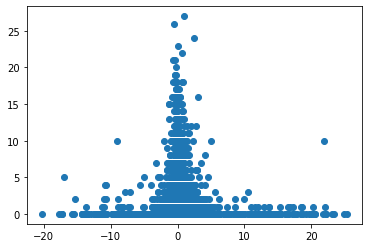

In [10]:
x = []
y = []

print(len(diffs))

for i in diffs:
    x.append(i[0])
    y.append(i[1])

plt.scatter(x,y)

In [11]:
print(len(x))

10360


In [12]:
for k in list(n_pass.keys()):
    print(k)
    print(n_pass[k])

hamilton
[497, 220]
heidfeld
[35, 40]
rosberg
[285, 231]
alonso
[436, 364]
kovalainen
[80, 166]
raikkonen
[507, 370]
kubica
[3, 64]
glock
[32, 133]
massa
[403, 315]
trulli
[28, 61]
sutil
[144, 162]
webber
[223, 111]
button
[320, 332]
vettel
[509, 262]
barrichello
[64, 63]
liuzzi
[13, 45]
michael_schumacher
[140, 104]
rosa
[24, 68]
karthikeyan
[21, 74]
buemi
[78, 66]
alguersuari
[79, 58]
grosjean
[412, 416]
kobayashi
[154, 160]
gasly
[197, 168]
hulkenberg
[367, 380]
petrov
[114, 137]
bruno_senna
[69, 83]
chandhok
[0, 2]
maldonado
[253, 290]
resta
[207, 199]
perez
[624, 471]
ambrosio
[17, 63]
ricciardo
[582, 408]
vergne
[199, 188]
pic
[52, 107]
chilton
[24, 73]
gutierrez
[141, 230]
bottas
[344, 284]
garde
[18, 55]
jules_bianchi
[23, 95]
kevin_magnussen
[193, 376]
kvyat
[290, 271]
ericsson
[136, 272]
stevens
[6, 30]
max_verstappen
[294, 151]
nasr
[89, 131]
sainz
[348, 280]
merhi
[4, 25]
rossi
[4, 17]
jolyon_palmer
[57, 114]
wehrlein
[59, 111]
haryanto
[5, 40]
vandoorne
[59, 80]
ocon
[143,

In [13]:
for k in list(v_pass.keys()):
    print(k)
    print(v_pass[k])

hamilton
[493.56221, 219.50272]
heidfeld
[34.71564, 39.99321]
rosberg
[282.65303, 230.17025]
alonso
[434.69893, 364.32063]
kovalainen
[79.64251, 167.83058]
raikkonen
[504.72632, 370.34016]
kubica
[3.00317, 64.85272]
glock
[32.07077, 135.51806]
massa
[400.27525, 315.05094]
trulli
[27.98211, 62.05226]
sutil
[144.02005, 163.30836]
webber
[220.45886, 110.49847]
button
[318.50141, 332.53395]
vettel
[505.78691, 261.66248]
barrichello
[63.71425, 63.61802]
liuzzi
[13.05351, 45.79457]
michael_schumacher
[138.69576, 103.75036]
rosa
[24.02872, 69.31779]
karthikeyan
[21.29236, 75.67161]
buemi
[77.80858, 66.19095]
alguersuari
[78.76069, 58.39564]
grosjean
[409.8651, 416.92213]
kobayashi
[153.50724, 161.47061]
gasly
[196.37044, 168.0012]
hulkenberg
[365.5446, 380.39076]
petrov
[113.66271, 137.84284]
bruno_senna
[67.77713, 82.9378]
chandhok
[0, 2.05234]
maldonado
[252.31325, 291.52258]
resta
[206.65303, 199.76662]
perez
[621.9674, 472.22199]
ambrosio
[17.13775, 64.50489]
ricciardo
[580.36057, 409.152

SyntaxError: invalid syntax (<ipython-input-14-f6460d7d9d2b>, line 1)